In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['January', 'February', 'March', 'April', 'October', 'November', 'December']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/oneHot_data.csv")

In [7]:
house_data.head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,Day,HourofDay,...,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,Thermostat_Motion,Remote_Sensor_1_Temperature,Remote_Sensor_1_Motion,T_out,RH_out
0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,11,0.330465,0.0,67.0,0.0,0.009112,1.808865
1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,2,9,0.330465,0.0,67.0,0.0,0.009112,1.808865
2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,20,20,0.330465,0.0,67.0,0.0,0.009112,1.808865
3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,9,12,0.330465,0.0,67.0,0.0,0.009112,1.808865
4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,8,0.330465,0.0,67.0,0.0,0.009112,1.808865


In [8]:
house_data.Month.value_counts()

4     7267
3     7132
12    7125
5     7123
11    6837
1     6797
10    6343
6     5986
2     4131
9       96
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
cumulative_df = pd.DataFrame({"T_ctrl": [], 
                              "T_stp_heat": [], 
                              "T_out" : [], 
                              "RH_out" : [],
                              "auxHeat1" : []})

# January

In [11]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5432, 34) (5432, 21) (1359, 34) (1359, 21)


In [12]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
544/544 [==============================] - 2s 4ms/step - loss: 1.3654 - accuracy: 0.7165 - val_loss: 1.0720 - val_accuracy: 0.7859
Epoch 2/20
544/544 [==============================] - 2s 3ms/step - loss: 1.0517 - accuracy: 0.7852 - val_loss: 1.0389 - val_accuracy: 0.7896
Epoch 3/20
544/544 [==============================] - 2s 4ms/step - loss: 1.0099 - accuracy: 0.7909 - val_loss: 1.0101 - val_accuracy: 0.7888
Epoch 4/20
544/544 [==============================] - 2s 3ms/step - loss: 0.9868 - accuracy: 0.7940 - val_loss: 0.9964 - val_accuracy: 0.7903
Epoch 5/20
544/544 [==============================] - 2s 3ms/step - loss: 0.9666 - accuracy: 0.7977 - val_loss: 0.9896 - val_accuracy: 0.7969
Epoch 6/20
544/544 [==============================] - 2s 3ms/step - loss: 0.9590 - accuracy: 0.7973 - val_loss: 0.9888 - val_accuracy: 0.7947
Epoch 7/20
544/544 [==============================] - 2s 3ms/step - loss: 0.9451 - accuracy: 0.7995 - val_loss: 0.9630 - val_accuracy: 0.8006
Epoch 

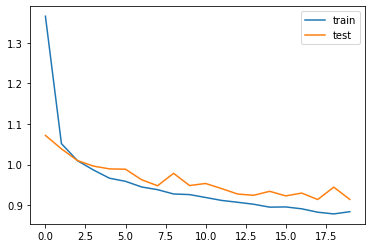

In [13]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

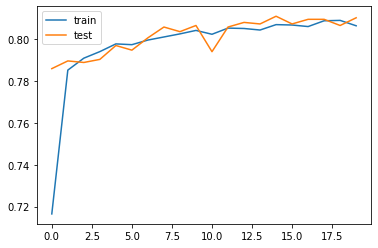

In [14]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [15]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

191160
193500
Error Percentage in predicted values is : 1.2241054613935969 %


In [16]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# February

In [17]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8737, 34) (8737, 21) (2185, 34) (2185, 21)


In [18]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
874/874 [==============================] - 3s 3ms/step - loss: 1.2993 - accuracy: 0.7334 - val_loss: 1.0880 - val_accuracy: 0.7712
Epoch 2/20
874/874 [==============================] - 3s 3ms/step - loss: 1.0510 - accuracy: 0.7817 - val_loss: 1.0380 - val_accuracy: 0.7794
Epoch 3/20
874/874 [==============================] - 3s 3ms/step - loss: 1.0231 - accuracy: 0.7870 - val_loss: 1.0200 - val_accuracy: 0.7812
Epoch 4/20
874/874 [==============================] - 3s 3ms/step - loss: 0.9992 - accuracy: 0.7917 - val_loss: 1.0087 - val_accuracy: 0.7835
Epoch 5/20
874/874 [==============================] - 3s 3ms/step - loss: 0.9842 - accuracy: 0.7946 - val_loss: 1.0071 - val_accuracy: 0.7844
Epoch 6/20
874/874 [==============================] - 3s 3ms/step - loss: 0.9758 - accuracy: 0.7942 - val_loss: 0.9922 - val_accuracy: 0.7822
Epoch 7/20
874/874 [==============================] - 3s 3ms/step - loss: 0.9687 - accuracy: 0.7946 - val_loss: 0.9723 - val_accuracy: 0.7899
Epoch 

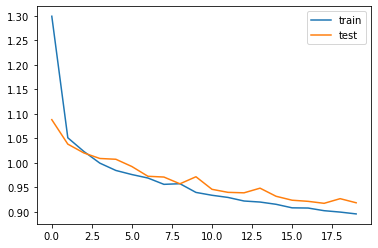

In [19]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

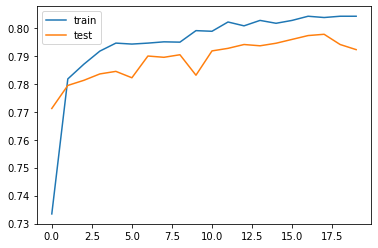

In [20]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [21]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

294465
286200
Error Percentage in predicted values is : 2.8067851866945137 %


In [22]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# March

In [23]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14443, 34) (14443, 21) (3611, 34) (3611, 21)


In [24]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.2859 - accuracy: 0.7307 - val_loss: 1.0255 - val_accuracy: 0.7898
Epoch 2/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.0891 - accuracy: 0.7737 - val_loss: 0.9776 - val_accuracy: 0.7984
Epoch 3/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.0505 - accuracy: 0.7790 - val_loss: 0.9540 - val_accuracy: 0.8017
Epoch 4/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.0229 - accuracy: 0.7828 - val_loss: 0.9324 - val_accuracy: 0.8037
Epoch 5/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.0074 - accuracy: 0.7854 - val_loss: 0.9187 - val_accuracy: 0.8053
Epoch 6/20
1445/1445 [==============================] - 5s 3ms/step - loss: 0.9944 - accuracy: 0.7877 - val_loss: 0.9048 - val_accuracy: 0.8092
Epoch 7/20
1445/1445 [==============================] - 5s 3ms/step - loss: 0.9842 - accuracy: 0.7881 - val_loss: 0.8967 - val_accuracy:

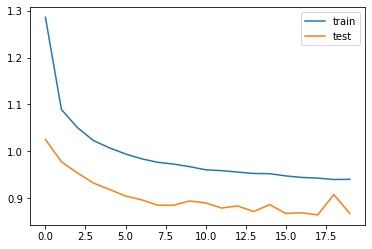

In [25]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

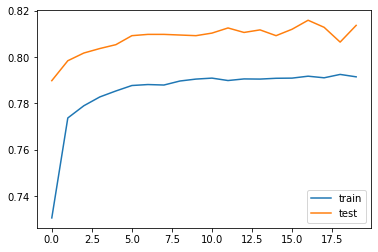

In [26]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [27]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

412440
416100
Error Percentage in predicted values is : 0.8874018038987489 %


In [28]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# April

In [29]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20256, 34) (20256, 21) (5065, 34) (5065, 21)


In [30]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2026/2026 [==============================] - 6s 3ms/step - loss: 1.0735 - accuracy: 0.7855 - val_loss: 0.9474 - val_accuracy: 0.8018
Epoch 2/20
2026/2026 [==============================] - 6s 3ms/step - loss: 0.9126 - accuracy: 0.8135 - val_loss: 0.9025 - val_accuracy: 0.8109
Epoch 3/20
2026/2026 [==============================] - 6s 3ms/step - loss: 0.8737 - accuracy: 0.8190 - val_loss: 0.8740 - val_accuracy: 0.8156
Epoch 4/20
2026/2026 [==============================] - 6s 3ms/step - loss: 0.8545 - accuracy: 0.8208 - val_loss: 0.8680 - val_accuracy: 0.8158
Epoch 5/20
2026/2026 [==============================] - 6s 3ms/step - loss: 0.8431 - accuracy: 0.8222 - val_loss: 0.8596 - val_accuracy: 0.8142
Epoch 6/20
2026/2026 [==============================] - 6s 3ms/step - loss: 0.8346 - accuracy: 0.8230 - val_loss: 0.8522 - val_accuracy: 0.8162
Epoch 7/20
2026/2026 [==============================] - 7s 3ms/step - loss: 0.8282 - accuracy: 0.8243 - val_loss: 0.8538 - val_accuracy:

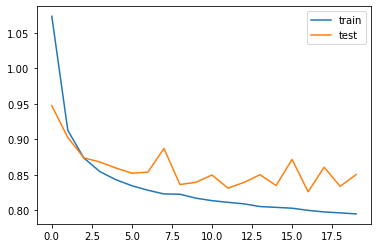

In [31]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

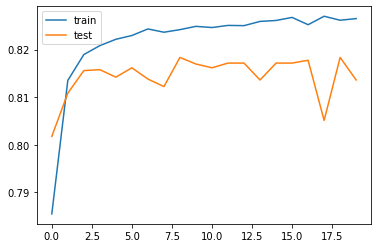

In [32]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [33]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

496230
434700
Error Percentage in predicted values is : 12.399492170969106 %


In [34]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# October

In [35]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25331, 34) (25331, 21) (6333, 34) (6333, 21)


In [36]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.9277 - accuracy: 0.8119 - val_loss: 0.8281 - val_accuracy: 0.8279
Epoch 2/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7837 - accuracy: 0.8395 - val_loss: 0.7828 - val_accuracy: 0.8389
Epoch 3/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7565 - accuracy: 0.8438 - val_loss: 0.7661 - val_accuracy: 0.8411
Epoch 4/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7403 - accuracy: 0.8447 - val_loss: 0.7444 - val_accuracy: 0.8460
Epoch 5/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7308 - accuracy: 0.8460 - val_loss: 0.7488 - val_accuracy: 0.8413
Epoch 6/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7248 - accuracy: 0.8465 - val_loss: 0.7433 - val_accuracy: 0.8462
Epoch 7/20
2534/2534 [==============================] - 8s 3ms/step - loss: 0.7186 - accuracy: 0.8463 - val_loss: 0.7380 - val_accuracy:

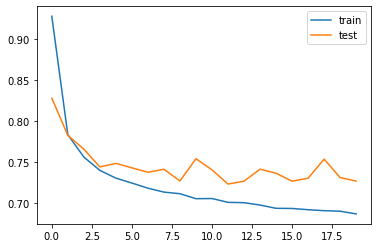

In [37]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

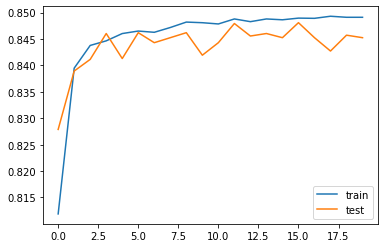

In [38]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [39]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

512115
449415
Error Percentage in predicted values is : 12.243343780205617 %


In [40]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7816467667261057

In [41]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [42]:
acc.append(max(history.history['accuracy']))

# November

In [43]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30800, 34) (30800, 21) (7701, 34) (7701, 21)


In [44]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.9388 - accuracy: 0.8130 - val_loss: 0.8191 - val_accuracy: 0.8305
Epoch 2/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.8026 - accuracy: 0.8328 - val_loss: 0.7835 - val_accuracy: 0.8372
Epoch 3/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.7755 - accuracy: 0.8374 - val_loss: 0.7790 - val_accuracy: 0.8326
Epoch 4/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.7640 - accuracy: 0.8374 - val_loss: 0.7687 - val_accuracy: 0.8396
Epoch 5/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.7575 - accuracy: 0.8389 - val_loss: 0.7547 - val_accuracy: 0.8382
Epoch 6/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.7527 - accuracy: 0.8392 - val_loss: 0.7435 - val_accuracy: 0.8407
Epoch 7/20
3080/3080 [==============================] - 9s 3ms/step - loss: 0.7473 - accuracy: 0.8401 - val_loss: 0.7416 - val_accuracy:

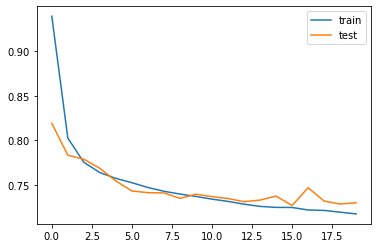

In [45]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

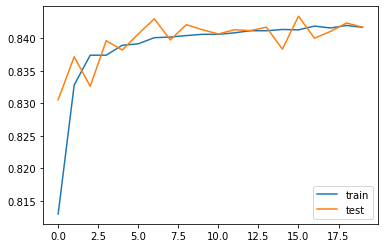

In [46]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [47]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

594435
606870
Error Percentage in predicted values is : 2.091902394710944 %


In [48]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7793416704353777

In [49]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [50]:
acc.append(max(history.history['accuracy']))

# December

In [51]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36500, 34) (36500, 21) (9126, 34) (9126, 21)


In [52]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3650/3650 [==============================] - 11s 3ms/step - loss: 0.9511 - accuracy: 0.8090 - val_loss: 0.8281 - val_accuracy: 0.8298
Epoch 2/20
3650/3650 [==============================] - 11s 3ms/step - loss: 0.8191 - accuracy: 0.8299 - val_loss: 0.7814 - val_accuracy: 0.8375
Epoch 3/20
3650/3650 [==============================] - 11s 3ms/step - loss: 0.7954 - accuracy: 0.8324 - val_loss: 0.7619 - val_accuracy: 0.8390
Epoch 4/20
3650/3650 [==============================] - 10s 3ms/step - loss: 0.7842 - accuracy: 0.8330 - val_loss: 0.7586 - val_accuracy: 0.8371
Epoch 5/20
3650/3650 [==============================] - 10s 3ms/step - loss: 0.7748 - accuracy: 0.8340 - val_loss: 0.7521 - val_accuracy: 0.8389
Epoch 6/20
3650/3650 [==============================] - 10s 3ms/step - loss: 0.7710 - accuracy: 0.8342 - val_loss: 0.7453 - val_accuracy: 0.8398
Epoch 7/20
3650/3650 [==============================] - 10s 3ms/step - loss: 0.7647 - accuracy: 0.8352 - val_loss: 0.7713 - val_ac

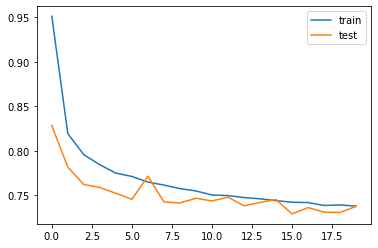

In [53]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

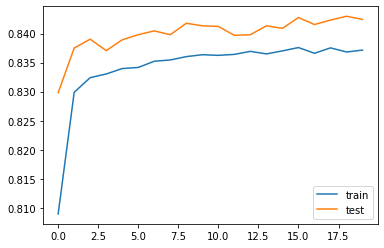

In [54]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [55]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

754515
745500
Error Percentage in predicted values is : 1.194807260293036 %


In [56]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7785005707719695

In [57]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [58]:
acc.append(max(history.history['accuracy']))

[Text(0, 0.5, 'Weighted F1-Score'), Text(0.5, 0, 'Data Upto & Including')]

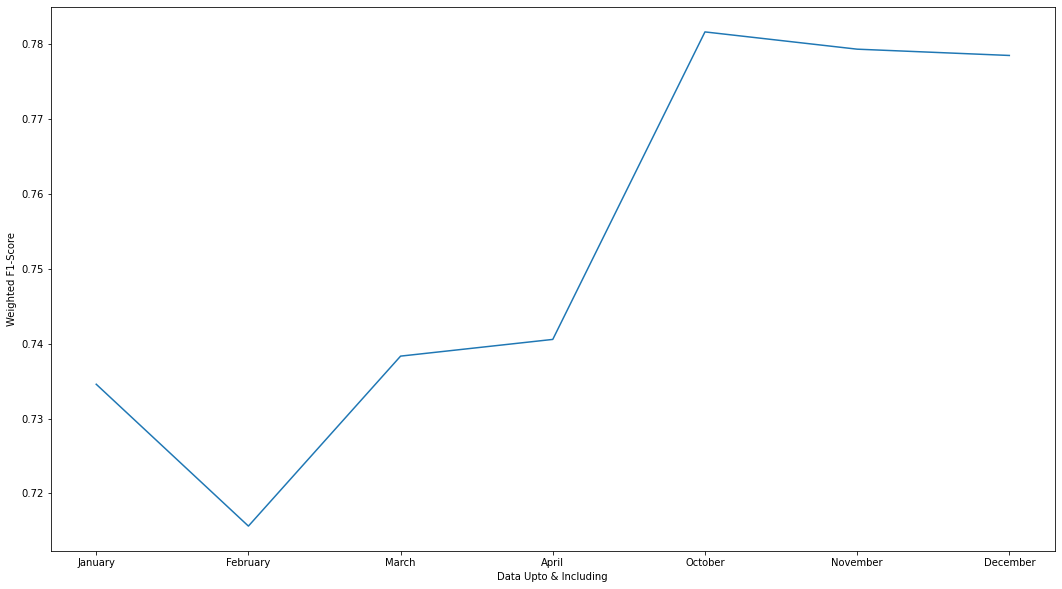

In [59]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = f1, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Weighted F1-Score")

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Data Upto & Including')]

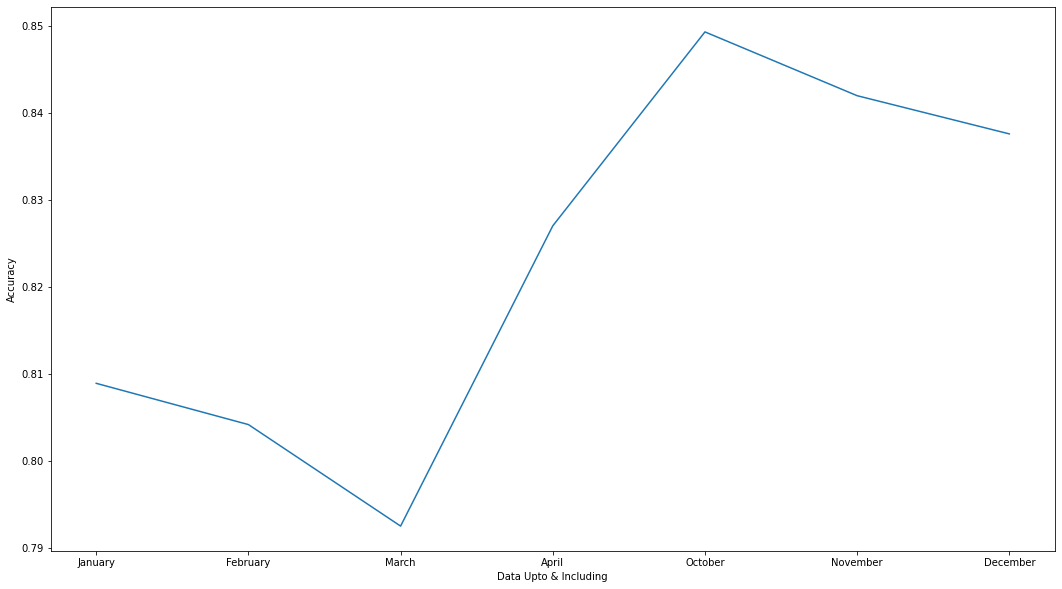

In [60]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = acc, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Accuracy")

[Text(0, 0.5, 'Error % in Prediction'), Text(0.5, 0, 'Data Upto & Including')]

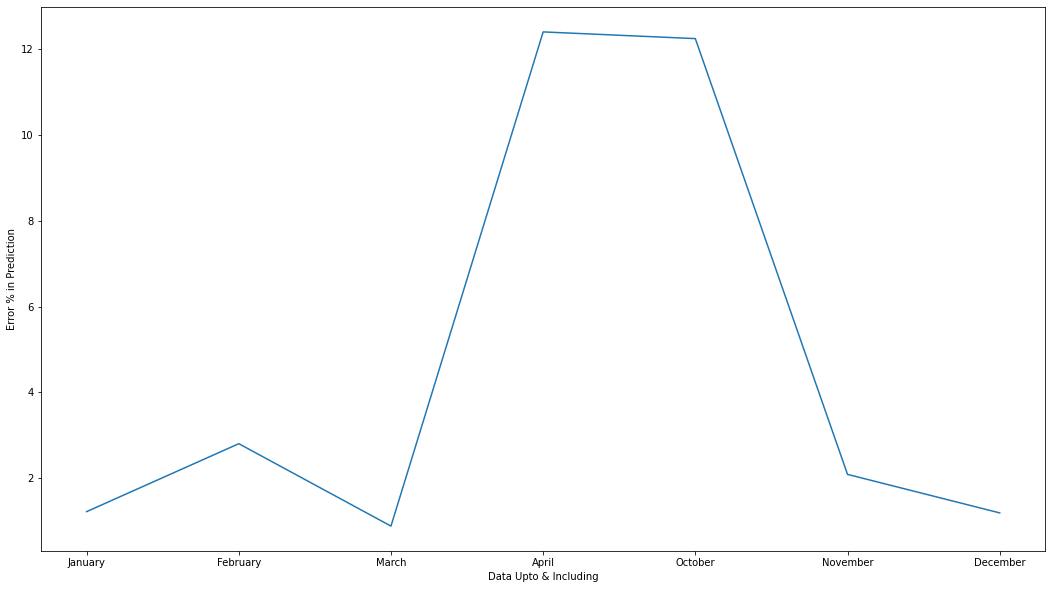

In [61]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = err, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Error % in Prediction")